In [1]:
# https://www.kaggle.com/zaburo/wip-reproduce-1st-place-solution

In [2]:
import numpy as np
import pandas as pd

import chainer
import chainer.links as L
import chainer.functions as F

from chainer import training
from chainer.training import extensions

from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, roc_auc_score

from scipy.special import erfinv

from trackml.dataset import load_event, load_dataset
from trackml.score import score_event

import torch
from torch import nn
from torch.utils.data import *
from torch.optim import *
# from fastai.model import *
# from fastai.column_data import *
# from fastai.dataloader import *
from torch.utils.data import DataLoader as torch_dl

from keras.models import Model
from keras.layers import Dense, Input
from keras.datasets import mnist
from keras.regularizers import l1
from keras.optimizers import Adam

import os
%matplotlib inline

ModuleNotFoundError: No module named 'chainer'

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

class Clusterer(object):
    
    def __init__(self, eps):
        self.eps = eps
        
    
    def _preprocess(self, hits):
        
        x = hits.x.values
        y = hits.y.values
        z = hits.z.values

        r = np.sqrt(x**2 + y**2 + z**2)
        hits['x2'] = x/r
        hits['y2'] = y/r

        r = np.sqrt(x**2 + y**2)
        hits['z2'] = z/r

        ss = StandardScaler()
        X = ss.fit_transform(hits[['x2', 'y2', 'z2']].values)
        
        return X
    
    
    def predict(self, hits):
        
        X = self._preprocess(hits)
        
        cl = DBSCAN(eps=self.eps, min_samples=1, algorithm='kd_tree')
        labels = cl.fit_predict(X)
        
        return labels

In [87]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

class Clusterer1(object):
    
    def __init__(self, eps):
        self.eps = eps
        
    
    def _preprocess(self, hits):
        
        x = hits.x.values
        y = hits.y.values
        z = hits.z.values

        r = np.sqrt(x**2 + y**2 + z**2)
        hits['x2'] = x/r
        hits['y2'] = y/r

        r = np.sqrt(x**2 + y**2)
        hits['z2'] = z/r

        ss = StandardScaler()
        X = ss.fit_transform(hits[['x2', 'y2', 'z2']].values)
        
        return X
    
    
    def predict(self, hits):
        
#         X = self._preprocess(hits)
        
        cl = DBSCAN(eps=self.eps, min_samples=1, algorithm='kd_tree')
        labels = cl.fit_predict(X)
        
        return labels

In [4]:
def create_one_event_submission(event_id, hits, labels):
    sub_data = np.column_stack(([event_id]*len(hits), hits.hit_id.values, labels))
    submission = pd.DataFrame(data=sub_data, columns=["event_id", "hit_id", "track_id"]).astype(int)
    return submission

In [5]:
class MLP(chainer.ChainList):

    def __init__(self, topology, dropout=-1, dropout_input=-1):
        super(MLP, self).__init__()
        self.total_hidden_dim = sum(topology[1:-1])
        self.dropout = dropout
        self.dropout_input = dropout_input
        self.b = None
        n_in = topology[0]
        for n_out in topology[1:]:
            self.add_link(L.Linear(n_in, n_out))
            n_in = n_out

    def get_hidden_concat(self, X):
        hidden_outputs = np.zeros((X.shape[0], self.total_hidden_dim), dtype=np.float32)
        child_links = list(self.children())

        next_start = 0
        for f in child_links[:-1]:
            X = F.relu(f(X))

            next_end = next_start + X.shape[1]
            hidden_outputs[:, next_start:next_end] = chainer.cuda.to_cpu(X.data)
            next_start = next_end

        return hidden_outputs

    def __call__(self, X):
        child_links = list(self.children())

        if self.dropout_input > 0:
            X = F.dropout(X, self.dropout_input)

        for f in child_links[:-1]:
            X = F.relu(f(X))
            if self.dropout > 0:
                X = F.dropout(X, self.dropout)

        y = child_links[-1](X)
        return y


class MSERegressor(chainer.Chain):

    def __init__(self, base_model):
        super(MSERegressor, self).__init__()
        with self.init_scope():
            self.base_model = base_model

    def __call__(self, X, y):
        y_hat = self.base_model(X)
        loss = F.mean_squared_error(y, y_hat)
        chainer.report({'loss': loss}, self)
        return loss


class SCEClassifier(chainer.Chain):

    def __init__(self, base_model):
        super(SCEClassifier, self).__init__()
        with self.init_scope():
            self.base_model = base_model

    def __call__(self, X, y):
        y_hat = self.base_model(X)
        loss = F.sigmoid_cross_entropy(y_hat[:, 0], y)
        chainer.report({'loss': loss}, self)
        return loss


class SwapNoiseIterator(chainer.iterators.SerialIterator):

    def __init__(self, X, noise_rate, batch_size, repeat=True, shuffle=True):
        self.X = X
        self.noise_rate = noise_rate
        self.batch_size = batch_size
        self._repeat = repeat
        self._shuffle = shuffle

        self.dataset = None
        self.reset_noise()
        self.reset()

    def reset_noise(self):
        X = self.X.copy()

        swap_idx = (np.random.uniform(0, 1, X.shape) < self.noise_rate)
        swap_nums = swap_idx.sum(axis=0)
        for i in range(X.shape[1]):
            X[swap_idx[:, i], i] = np.random.choice(self.X[:, i], swap_nums[i])

        self.dataset = chainer.datasets.TupleDataset(X, self.X)

    def __next__(self):
        # All lines are the same as the original SerialIterator
        # except the line `self.reset_noise()`

        if not self._repeat and self.epoch > 0:
            raise StopIteration

        self._previous_epoch_detail = self.epoch_detail

        i = self.current_position
        i_end = i + self.batch_size
        N = len(self.dataset)

        if self._order is None:
            batch = self.dataset[i:i_end]
        else:
            batch = [self.dataset[index] for index in self._order[i:i_end]]

        if i_end >= N:
            if self._repeat:
                rest = i_end - N
                if self._order is not None:
                    np.random.shuffle(self._order)

                self.reset_noise()

                if rest > 0:
                    if self._order is None:
                        batch.extend(self.dataset[:rest])
                    else:
                        batch.extend([self.dataset[index]
                                      for index in self._order[:rest]])
                self.current_position = rest
            else:
                self.current_position = 0

            self.epoch += 1
            self.is_new_epoch = True
        else:
            self.is_new_epoch = False
            self.current_position = i_end

        return batch

    next = __next__

    def reset(self):
        super(SwapNoiseIterator, self).reset()


def fit(model, iterator, settings, gpu):
    if gpu >= 0:
        model.to_gpu(gpu)

    optimizer = chainer.optimizers.SGD(lr=settings['learning_rate'])
    optimizer.setup(model)
    if 'reg_l2' in settings:
        optimizer.add_hook(chainer.optimizer.WeightDecay(settings['reg_l2']))
    print(optimizer.lr)

    updater = training.StandardUpdater(iterator, optimizer, device=gpu)
    trainer = training.Trainer(updater, (settings['nb_epochs'], 'epoch'))

    trainer.extend(extensions.ExponentialShift('lr', settings['learning_rate_decay']),
                   trigger=(1, 'epoch'))
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'elapsed_time']))
    trainer.extend(extensions.ProgressBar())

    trainer.run()
    print(optimizer.lr)


def predict(model, iterator, gpu):
    iterator.reset()

    pred = None
    next_start = 0

    with chainer.no_backprop_mode(), chainer.using_config('train', False):
        for batch in iterator:
            X_batch = chainer.dataset.concat_examples(batch, gpu)[0]
            y_hat = model(X_batch)

            if isinstance(y_hat, chainer.Variable):
                y_hat = y_hat.data

            y_hat = chainer.cuda.to_cpu(y_hat)

            if pred is None:
                pred = np.zeros((len(iterator.dataset), y_hat.shape[1]), dtype=np.float32)

            next_end = next_start + y_hat.shape[0]
            pred[next_start:next_end] = y_hat
            next_start = next_end

    return pred




In [6]:
seed = 1024
gpu = -1
submission_name = '../submissions/submission.csv'

In [7]:
np.random.seed(seed)
if gpu >= 0:
    chainer.cuda.get_device_from_id(gpu).use()

In [8]:
# now read 1 event
path_to_train = "../data/train"
event_prefix = "event000001000"
hits, cells, particles, truth = load_event(os.path.join(path_to_train, event_prefix))

In [9]:
model = Clusterer(eps=0.008)
labels = model.predict(hits)

In [10]:
submission = create_one_event_submission(0, hits, labels)
score = score_event(truth, submission)

In [11]:
print(score)

0.1988556913647304


In [12]:
X = hits[['x', 'y', 'z']]

In [13]:
X.shape

(120939, 3)

In [14]:
X.head()

,x,y,z
0,-64.409897,-7.163700,-1502.5
1,-55.336102,0.635342,-1502.5
2,-83.830498,-1.143010,-1502.5
3,-96.109100,-8.241030,-1502.5
4,-62.673599,-9.371200,-1502.5


In [15]:
trafo_columns = ['x', 'y', 'z']

In [16]:
# Gauss Rank transformation
for col in trafo_columns:
    values = sorted(set(X[col]))
    # Because erfinv(1) is inf, we shrink the range into (-0.9, 0.9)
    f = pd.Series(np.linspace(-0.9, 0.9, len(values)), index=values)
    f = np.sqrt(2) * erfinv(f)
    f -= f.mean()
    X[col] = X[col].map(f)

/home/watts/anaconda3/envs/tml/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
X = X.values.astype(np.float32)

In [49]:
# train denoising autoencoder
settings = {
    'topology': [3, 100, 100, 100, 3],
    'learning_rate': 1e-3,
    'batch_size': 128,
    'learning_rate_decay': 0.995,
    'swap_noise': 0.15,
    'nb_epochs': 10
}

In [50]:
autoencoder = MLP(settings['topology'])

In [51]:
model = MSERegressor(autoencoder)

In [52]:
iterator = SwapNoiseIterator(X, settings['swap_noise'], settings['batch_size'])

In [53]:
fit(model, iterator, settings, gpu)


0.001
epoch       main/loss   elapsed_time
     total [..................................................]  1.06%
this epoch [#####.............................................] 10.58%
       100 iter, 0 epoch / 10 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
     total [#.................................................]  2.12%
this epoch [##########........................................] 21.17%
       200 iter, 0 epoch / 10 epochs
    250.51 iters/sec. Estimated time to finish: 0:00:36.917815.
     total [#.................................................]  3.18%
this epoch [###############...................................] 31.75%
       300 iter, 0 epoch / 10 epochs
    248.41 iters/sec. Estimated time to finish: 0:00:36.827199.
     total [##................................................]  4.23%
this epoch [#####################.............................] 42.34%
       400 iter, 0 epoch / 10 epochs
    248.47 iters/sec. Estimated time to finish: 0:00:36.

     total [#################.................................] 35.99%
this epoch [#############################.....................] 59.85%
      3400 iter, 3 epoch / 10 epochs
    249.79 iters/sec. Estimated time to finish: 0:00:24.214024.
     total [##################................................] 37.04%
this epoch [###################################...............] 70.43%
      3500 iter, 3 epoch / 10 epochs
    249.99 iters/sec. Estimated time to finish: 0:00:23.794509.
     total [###################...............................] 38.10%
this epoch [########################################..........] 81.02%
      3600 iter, 3 epoch / 10 epochs
    250.16 iters/sec. Estimated time to finish: 0:00:23.378335.
     total [###################...............................] 39.16%
this epoch [#############################################.....] 91.60%
      3700 iter, 3 epoch / 10 epochs
    250.13 iters/sec. Estimated time to finish: 0:00:22.981263.
4           0.25679     15.0

7           0.258265    24.5893       
     total [###################################...............] 70.91%
this epoch [####..............................................]  9.12%
      6700 iter, 7 epoch / 10 epochs
     267.7 iters/sec. Estimated time to finish: 0:00:10.266525.
     total [###################################...............] 71.97%
this epoch [#########.........................................] 19.70%
      6800 iter, 7 epoch / 10 epochs
    267.36 iters/sec. Estimated time to finish: 0:00:09.905572.
     total [####################################..............] 73.03%
this epoch [###############...................................] 30.29%
      6900 iter, 7 epoch / 10 epochs
    266.93 iters/sec. Estimated time to finish: 0:00:09.546907.
     total [#####################################.............] 74.09%
this epoch [####################..............................] 40.87%
      7000 iter, 7 epoch / 10 epochs
     266.6 iters/sec. Estimated time to finish: 0:00:

In [54]:
chainer.serializers.save_npz('../cache/dae.npz', autoencoder)

In [55]:
# extract hidden layer's outputs.
iterator = chainer.iterators.SerialIterator(chainer.datasets.TupleDataset(X),
                                            settings['batch_size'], repeat=False, shuffle=False)


In [56]:
transformed = predict(autoencoder.get_hidden_concat, iterator, gpu)

In [57]:
transformed.shape

(120939, 300)

In [59]:
transformed

array([[0.02773226, 1.2126997 , 1.1007833 , ..., 1.2524167 , 0.9152157 ,
        0.        ],
       [0.00767012, 1.1918355 , 1.0629389 , ..., 1.2072154 , 0.8939854 ,
        0.        ],
       [0.        , 1.2096784 , 1.2005502 , ..., 1.2777227 , 0.9145684 ,
        0.        ],
       ...,
       [0.        , 0.        , 1.0201601 , ..., 1.2345532 , 0.        ,
        0.4340189 ],
       [0.        , 0.        , 0.96291876, ..., 1.2730985 , 0.        ,
        0.35862383],
       [0.        , 0.        , 0.932927  , ..., 1.2943891 , 0.        ,
        0.33030686]], dtype=float32)

In [60]:
t1 = predict(autoencoder, iterator, gpu)

In [61]:
t1.shape

(120939, 3)

In [169]:
df_t1 = pd.DataFrame(t1)

In [170]:
df_t1.head()

,0,1,2
0,-0.409690,-0.016581,-1.341979
1,-0.363309,0.022930,-1.337803
2,-0.477135,-0.023108,-1.343519
3,-0.517259,-0.055789,-1.350732
4,-0.404917,-0.022886,-1.344337


In [171]:
df_t1.columns = ['x', 'y', 'z']

In [172]:
model = Clusterer(eps=0.008)
labels = model.predict(df_t1)

In [173]:
df_t1['hit_id'] = hits.hit_id.values

In [174]:
submission = create_one_event_submission(0, df_t1, labels)
score = score_event(truth, submission)

In [175]:
print(score)

0.0005919957141459519


In [96]:
from sklearn.decomposition import PCA

In [97]:
pca = PCA(n_components=3)

In [100]:
X1 = pca.fit_transform(transformed)

In [101]:
X1.shape

(120939, 3)

In [102]:
X1

array([[ 6.8402724 ,  0.68619484,  1.1305367 ],
       [ 6.7369323 ,  0.29595616,  1.1665802 ],
       [ 6.8455243 ,  0.81368494,  1.4427891 ],
       ...,
       [-5.1111493 ,  3.1884348 ,  3.9302871 ],
       [-4.971294  ,  3.8695283 ,  3.5528095 ],
       [-4.885525  ,  4.2590528 ,  3.3413584 ]], dtype=float32)

In [153]:
df_x1 = pd.DataFrame(X1)

In [154]:
df_x1.columns = ['x', 'y', 'z']

In [155]:
model = Clusterer(eps=0.008)
labels = model.predict(df_x1)

In [156]:
df_x1['hit_id'] = hits.hit_id.values

In [157]:
# df_x1['hit_id'] = df_x1.hit_id.values[::-1]

In [158]:
df_x1.head()

,x,y,z,x2,y2,z2,hit_id
0,6.840272,0.686195,1.130537,0.981818,0.098493,0.164451,120939
1,6.736932,0.295956,1.166580,0.984415,0.043246,0.172995,120938
2,6.845524,0.813685,1.442789,0.971951,0.115530,0.209291,120937
3,6.930990,1.134756,1.410117,0.967552,0.158410,0.200778,120936
4,6.857177,0.723979,1.071072,0.982688,0.103752,0.155334,120935


In [159]:
labels

array([    0,     1,     2, ..., 11086, 39638, 30457])

In [160]:
submission = create_one_event_submission(0, df_x1, labels)
score = score_event(truth, submission)

In [161]:
score

0.0

In [145]:
submission

,event_id,hit_id,track_id
0,0,1,0
1,0,2,1
2,0,3,2
3,0,4,3
4,0,5,0
5,0,6,0
6,0,7,0
7,0,8,4
8,0,9,5
9,0,10,6


In [129]:
print(score)

0.0006715291938320091


In [177]:
# say we have a straight line function
# y = mx + c
# let m = 5, c = 20, x in {0, 100}
x = torch.FloatTensor(2500).random_(0, 100)

In [178]:
m =5
c = 20

In [179]:
y = m * x + c

In [180]:
y

tensor([  95.,  280.,  480.,  ...,  305.,  480.,  240.])

In [182]:
import matplotlib.pyplot as plt

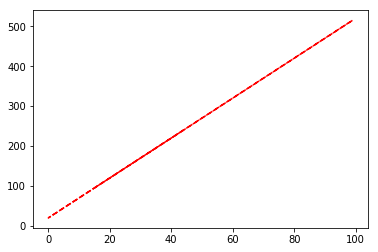

In [190]:
plt.plot(x.cpu().numpy(), y.cpu().numpy(), 'r--')
plt.show()

In [194]:
# now add some noise
X = x.cpu().numpy()
Y = y.cpu().numpy()

In [196]:
X = X+ 20*np.random.randn(2500)
Y = Y + 20*np.random.randn(2500) 

In [197]:
X

array([ 12.56277102,  49.57012975, 125.28102951, ...,  77.01967762,
        56.18320855,  52.24584259])

In [198]:
Y

array([109.52688216, 281.92500073, 502.88498453, ..., 280.5327945 ,
       502.4524292 , 242.19154682])

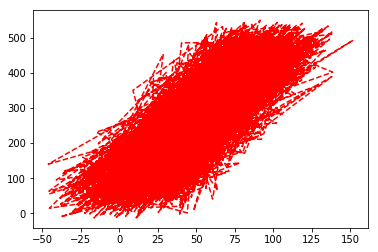

In [199]:
plt.plot(X, Y, 'r--')
plt.show()

In [200]:
X.shape

(2500,)

In [203]:
df = pd.DataFrame(X)

In [204]:
df.head()

,0
0,12.562771
1,49.570130
2,125.281030
3,33.668240
4,86.578204


In [206]:
df.columns = ['x']

In [207]:
df.head()

,x
0,12.562771
1,49.570130
2,125.281030
3,33.668240
4,86.578204


In [208]:
df['y'] = Y

In [209]:
df.head()

,x,y
0,12.562771,109.526882
1,49.570130,281.925001
2,125.281030,502.884985
3,33.668240,159.873553
4,86.578204,492.603055


ModuleNotFoundError: No module named 'keras'

In [210]:
input_size = 5000
hidden_size = 128
code_size = 32

input_img = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(input_img)
code = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_img = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='mse')

SyntaxError: EOL while scanning string literal (<ipython-input-210-ac967de8b0a4>, line 12)